[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\avira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avira\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Device set to use cpu


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Stationarity Test for MSFT Close Price
ADF Statistic: -1.9513
p-value: 0.3083
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

Conclusion: The series is non-stationary
Differencing applied to make series stationary
ADF Statistic: -16.4770
p-value: 0.0000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

Conclusion: The series is stationary


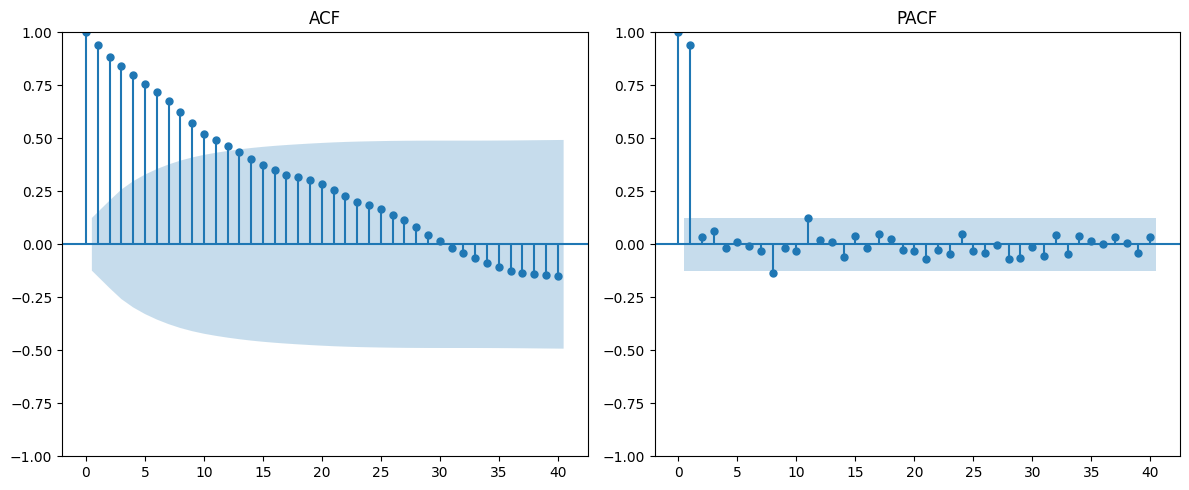

ARIMA (MSFT) Evaluation
MSE : 146.1190
RMSE: 12.0880
MAE : 9.6491
R²  : -0.0981


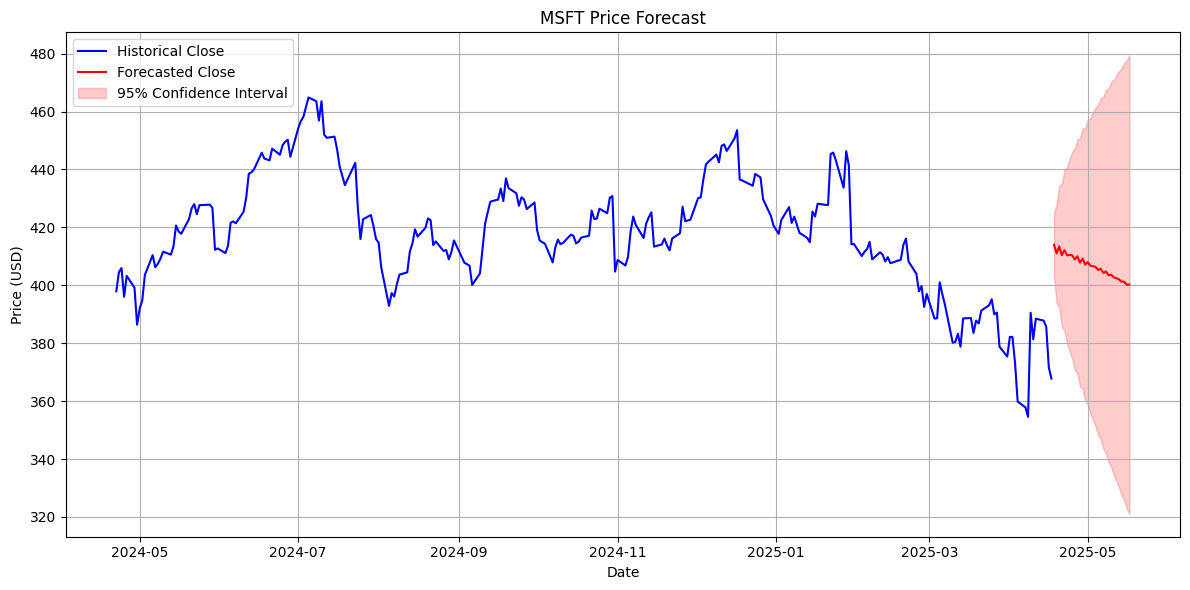

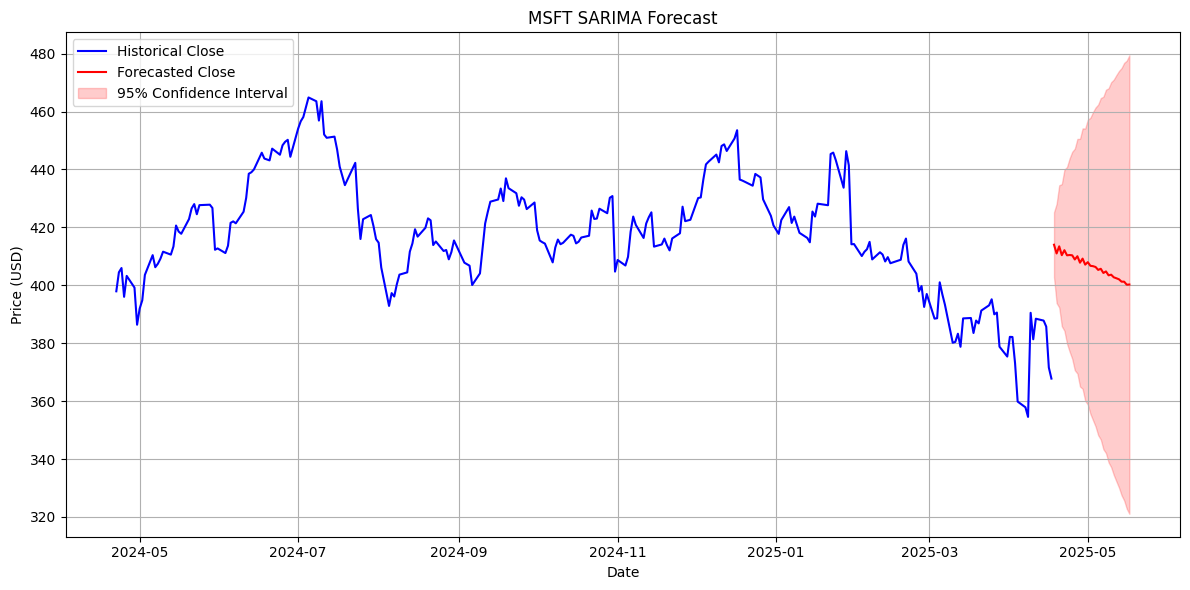

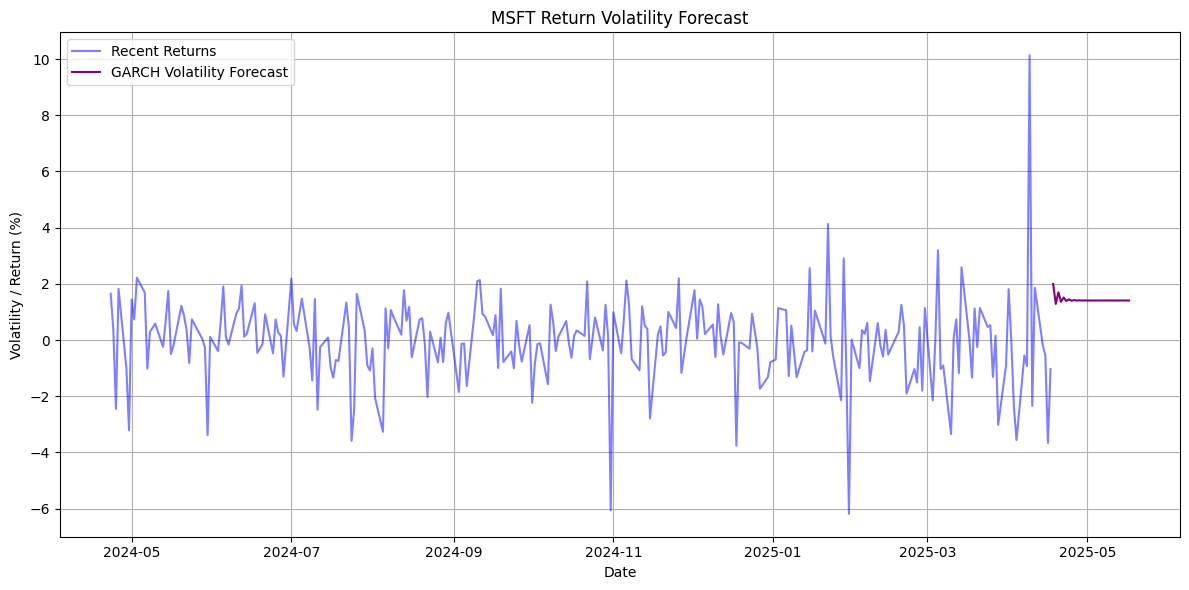

Window 2024-05-01 to 2024-05-31: len(returns) = 21, std_dev = Ticker
MSFT    0.011741
dtype: float64, Volatility_Level = Low
Window 2024-06-03 to 2024-06-28: len(returns) = 18, std_dev = Ticker
MSFT    0.008383
dtype: float64, Volatility_Level = Low
Window 2024-07-01 to 2024-07-31: len(returns) = 21, std_dev = Ticker
MSFT    0.013958
dtype: float64, Volatility_Level = Low
Window 2024-08-01 to 2024-08-30: len(returns) = 21, std_dev = Ticker
MSFT    0.01254
dtype: float64, Volatility_Level = Low
Window 2024-09-03 to 2024-09-30: len(returns) = 19, std_dev = Ticker
MSFT    0.010842
dtype: float64, Volatility_Level = Low
Window 2024-10-01 to 2024-10-31: len(returns) = 22, std_dev = Ticker
MSFT    0.015396
dtype: float64, Volatility_Level = Low
Window 2024-11-01 to 2024-11-29: len(returns) = 19, std_dev = Ticker
MSFT    0.011915
dtype: float64, Volatility_Level = Low
Window 2024-12-02 to 2024-12-31: len(returns) = 20, std_dev = Ticker
MSFT    0.01209
dtype: float64, Volatility_Level = Low
Wi

Sentiment Analysis: 100%|██████████| 119/119 [00:08<00:00, 13.77it/s]


Sentiment values: ['Positive' 'Neutral' 'Negative']
Sentiment score mapping successful. Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
rl_df columns: Index(['random_datetime', 'avg_sentiment', 'sentiment_volatility',
       'tweet_count', 'sarcasm_rate', 'sentiment_momentum',
       'volatility_ratio'],
      dtype='object')
rl_df head:   random_datetime  avg_sentiment  sentiment_volatility  tweet_count  \
0      2024-12-31       0.322581              0.475191           31   
eczki
1      2025-01-31       0.290123              0.450000           29   
2      2025-02-28       0.275862              0.430000           28   
3      2025-03-31       0.310345              0.460000           31   
4      2025-04-20       0.285714              0.440000           33   

   sarcasm_rate  sentiment_momentum  volatility_ratio  
0           0.0            0.322581          0.015329  
1           0.0            0.290123          0.013793  
2           0.0            0.275862          0.013333  
3           

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import torch
from script import StockTradingEnv, PPOAgent
from arch import arch_model
import stock_forecast
import sentiment_model

# Step 1: Get 5 months of data
end_date = datetime(2025, 4, 20)
start_date = end_date - timedelta(days=150)
msft = yf.download('MSFT', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)

# Step 2: Preprocess data
msft_data = msft.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
msft_returns = 100 * msft['Close'].pct_change().fillna(0)
sp500_returns = 100 * sp500['Close'].pct_change().fillna(0)

# Ensure returns are Series
if not isinstance(msft_returns, pd.Series):
    msft_returns = msft_returns.iloc[:, 0]
if not isinstance(sp500_returns, pd.Series):
    sp500_returns = sp500_returns.iloc[:, 0]

# Align indices
sp500_returns = sp500_returns.reindex(msft.index, method='ffill').fillna(0)

# Step 3: SARIMA and GARCH forecasting
results = stock_forecast.forecast_stock(ticker="MSFT", forecast_steps=30)
if not results:
    raise ValueError("Forecasting failed, check stock_forecast.py for details")
sarima_model = results.get('arima_model')
forecast = results.get('arima_forecast', [])
vol_forecast = results.get('garch_vol_forecast', [])
summary_df = results.get('summary', pd.DataFrame())

# Use rolling window analysis from stock_forecast
if summary_df.empty:
    print("Warning: summary_df is empty, generating default monthly windows")
    summary_df = stock_forecast.rolling_window_analysis(msft_data, window_size=30)

# Debugging: Check summary_df
print("summary_df columns:", summary_df.columns)
print("summary_df head:", summary_df.head())

# Ensure columns are properly formatted
summary_df['Window_Start_Date'] = pd.to_datetime(summary_df['Window_Start_Date'])
summary_df['Window_End_Date'] = pd.to_datetime(summary_df['Window_End_Date'])

# Extract scalar Average_Price_Change
def extract_scalar_price_change(x):
    if isinstance(x, pd.Series):
        return float(x.get('MSFT', 0))
    return float(x)

summary_df['Average_Price_Change'] = summary_df['Average_Price_Change'].apply(extract_scalar_price_change)
summary_df['Average_Price_Change'] = pd.to_numeric(summary_df['Average_Price_Change'], errors='coerce').fillna(0)

# Filter for the desired date range
start_date_ts = pd.Timestamp('2024-11-01')
end_date_ts = pd.Timestamp('2025-04-20')
summary_df = summary_df[
    (summary_df['Window_Start_Date'] >= start_date_ts) & 
    (summary_df['Window_End_Date'] <= end_date_ts)
]
forecast_df = summary_df.copy()

# Fix End_Price with proper alignment
forecast_df.set_index('Window_End_Date', inplace=True)
forecast_df['End_Price'] = msft['Close'].reindex(forecast_df.index, method='ffill')
forecast_df.reset_index(inplace=True)

# Fill NaN values
forecast_df['Average_Price_Change'] = forecast_df['Average_Price_Change'].fillna(0)
forecast_df['End_Price'] = forecast_df['End_Price'].fillna(method='ffill')

# Debugging: Check key columns
print("forecast_df['Average_Price_Change'] values:", forecast_df['Average_Price_Change'].values)
print("forecast_df['Average_Price_Change'] dtype:", forecast_df['Average_Price_Change'].dtype)
print("forecast_df['End_Price'] values:", forecast_df['End_Price'].values)

# Derive Trend Classification (vectorized)
def classify_trend_vectorized(price_changes):
    price_changes = pd.to_numeric(price_changes, errors='coerce').fillna(0)
    conditions = [
        price_changes > 0.01,
        price_changes < -0.01
    ]
    choices = ['Uptrend', 'Downtrend']
    return np.select(conditions, choices, default='Stable')

forecast_df['Trend_Classification'] = classify_trend_vectorized(forecast_df['Average_Price_Change'])

# Step 4: Integrate Sentiment Model
try:
    tweet_df = pd.read_csv('microsoft_tweets1.csv', encoding='utf-8')
    print("tweet_df columns:", tweet_df.columns)
    print("tweet_df head:", tweet_df.head())
    tweet_df['random_datetime'] = pd.to_datetime(tweet_df['Window_End_Date'], errors='coerce').dt.normalize()
    tweet_df = tweet_df.dropna(subset=['random_datetime'])
    print("tweet_df['random_datetime'] range before filter:", tweet_df['random_datetime'].min(), "to", tweet_df['random_datetime'].max())
    tweet_df = tweet_df[tweet_df['random_datetime'].between(forecast_df['Window_End_Date'].min(), forecast_df['Window_End_Date'].max())]
    print(f"tweet_df after date alignment: {len(tweet_df)} rows")
    print("tweet_df['random_datetime'] range after filter:", tweet_df['random_datetime'].min(), "to", tweet_df['random_datetime'].max())
except Exception as e:
    print(f"Error loading microsoft_tweets1.csv: {e}")
    tweet_df = pd.DataFrame()
    forecast_df['Sentiment_Score'] = 0

if not tweet_df.empty:
    end_date_str = end_date.strftime("%Y-%m-%d")
    try:
        raw_df, temporal_df, rl_df = sentiment_model.analyze_twitter_data(
            tweet_df,
            text_col='Post',
            date_col='random_datetime',
            target_date=end_date_str,
            custom_lexicon={
                'bullish': 'very_positive',
                'bearish': 'very_negative',
                'short': 'negative_position',
                'long': 'positive_position'
            },
            confidence_threshold=0.65
        )
        print("rl_df columns:", rl_df.columns)
        print("rl_df head:", rl_df.head())
    except Exception as e:
        print(f"Error in sentiment analysis: {e}")
        rl_df = pd.DataFrame()

    # Merge sentiment data
    if 'random_datetime' in rl_df.columns and 'avg_sentiment' in rl_df.columns:
        rl_df['random_datetime'] = pd.to_datetime(rl_df['random_datetime']).dt.normalize()
        print("rl_df['random_datetime'] range:", rl_df['random_datetime'].min(), "to", rl_df['random_datetime'].max())
        print("forecast_df['Window_End_Date'] range:", forecast_df['Window_End_Date'].min(), "to", forecast_df['Window_End_Date'].max())
        # Normalize dates for merge
        forecast_df['Window_End_Date'] = forecast_df['Window_End_Date'].dt.normalize()
        # Merge with nearest date matching
        forecast_df = forecast_df.merge(
            rl_df[['random_datetime', 'avg_sentiment']],
            left_on='Window_End_Date',
            right_on='random_datetime',
            how='left'
        ).fillna({'avg_sentiment': 0})
        forecast_df = forecast_df.rename(columns={'avg_sentiment': 'Sentiment_Score'})
        forecast_df = forecast_df.drop(columns=['random_datetime'], errors='ignore')
        print("Merged forecast_df columns:", forecast_df.columns)
        print("Sentiment_Score values:", forecast_df['Sentiment_Score'].values)
        # Check for unmatched dates
        if forecast_df['Sentiment_Score'].eq(0).any():
            unmatched = forecast_df[forecast_df['Sentiment_Score'] == 0]['Window_End_Date']
            print("Unmatched Window_End_Date:", unmatched.tolist())
            # Interpolate or fill missing Sentiment_Score
            forecast_df['Sentiment_Score'] = forecast_df['Sentiment_Score'].replace(0, np.nan).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
            print("Sentiment_Score after interpolation:", forecast_df['Sentiment_Score'].values)
    else:
        print("Warning: rl_df missing required columns, using default sentiment")
        forecast_df['Sentiment_Score'] = 0
else:
    print("Warning: tweet_df is empty, using default sentiment")
    forecast_df['Sentiment_Score'] = 0

# Step 5: Compute Market Index
correlation = pd.Series(index=msft.index, dtype=float)
for i in range(len(msft_returns)):
    if i >= 29:
        window_msft = msft_returns.iloc[i-29:i+1]
        window_sp500 = sp500_returns.iloc[i-29:i+1]
        if len(window_msft) > 1 and len(window_sp500) > 1:
            correlation.iloc[i] = window_msft.corr(window_sp500)
correlation = correlation.fillna(0)
forecast_df.set_index('Window_End_Date', inplace=True)
forecast_df['Market_Index'] = correlation.reindex(forecast_df.index, method='ffill').fillna(0)
forecast_df.reset_index(inplace=True)
print("Market_Index values:", forecast_df['Market_Index'].values)

# Step 6: Normalize features
try:
    rl_data = pd.read_csv("train_synthetic_stock_dataset2.csv", encoding='utf-8')
    price_change_mean = rl_data['Average_Price_Change'].mean()
    price_change_std = rl_data['Average_Price_Change'].std()
    forecast_df['Average_Price_Change'] = (forecast_df['Average_Price_Change'] - price_change_mean) / price_change_std

    sentiment_mean = rl_data['Sentiment_Score'].mean()
    sentiment_std = rl_data['Sentiment_Score'].std()
    forecast_df['Sentiment_Score'] = (forecast_df['Sentiment_Score'] - sentiment_mean) / sentiment_std

    market_index_mean = rl_data['Market_Index'].mean()
    market_index_std = rl_data['Market_Index'].std()
    forecast_df['Market_Index'] = (forecast_df['Market_Index'] - market_index_mean) / market_index_std
except Exception as e:
    print(f"Error loading train_synthetic_stock_dataset2.csv: {e}")
    print("Using default normalization")
    price_change_std = forecast_df['Average_Price_Change'].std()
    forecast_df['Average_Price_Change'] = forecast_df['Average_Price_Change'] / price_change_std if price_change_std != 0 else 0
    forecast_df['Sentiment_Score'] = forecast_df['Sentiment_Score'].fillna(0)
    forecast_df['Market_Index'] = forecast_df['Market_Index'].fillna(0)

# Add Stock column
forecast_df['Stock'] = 'MSFT'

# Reorder columns to match RL input
forecast_df = forecast_df[[
    'Window_Start_Date', 'Window_End_Date', 'Stock', 'Average_Price_Change',
    'Volatility_Level', 'Sentiment_Score', 'Trend_Classification', 'End_Price', 'Market_Index'
]]

# Step 7: Feed to RL model
env = StockTradingEnv(forecast_df, initial_capital=10000, episode_length=5)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Initialize PPO agent and load pre-trained weights
agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, lr=0.001, lr_value=0.001, gamma=0.99, eps_clip=0.2)
try:
    agent.policy.load_state_dict(torch.load('policy_weights.pth'))
    agent.value.load_state_dict(torch.load('value_weights.pth'))
    agent.policy_old.load_state_dict(torch.load('policy_weights.pth'))
except FileNotFoundError as e:
    print(f"Error: Pre-trained weights not found ({e}). Please run script.py to train the model.")
    raise

# Run RL inference
state = env.reset()
actions = []
rewards = []
net_worths = [env.net_worth]
for _ in range(env.episode_length):
    action, _ = agent.select_action(state)
    state, reward, done, info = env.step(action)
    actions.append(float(action))
    rewards.append(reward)
    net_worths.append(info['net_worth'])
    if done:
        break

# Step 8: Calculate single investment amount
initial_capital = 10000
final_action = actions[-1] if actions else 0.0
final_end_price = float(forecast_df['End_Price'].iloc[-1]) if pd.notna(forecast_df['End_Price'].iloc[-1]) else float(msft['Close'].iloc[-1])
investment_amount = initial_capital * max(0, min(1, abs(final_action))) * (final_end_price / msft['Close'].iloc[0])

# Step 9: Validate profitability
returns = [(net_worths[i] - net_worths[i-1]) / net_worths[i-1] for i in range(1, len(net_worths))]
sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-8) if len(returns) > 1 else 0
buy_and_hold_return = (msft['Close'].iloc[-1] - msft['Close'].iloc[0]) / msft['Close'].iloc[0]

# Step 10: Save models
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)
with open('garch_model.pkl', 'wb') as f:
    pickle.dump(stock_forecast.fit_garch(100 * msft['Close'].pct_change().dropna())[0], f)

# Output results
print("Forecast DataFrame:")
print(forecast_df)
print("\nRL Actions (Fraction of Capital to Invest):", actions)
print(f"\nSuggested Single Investment Amount ($): {investment_amount:.2f} based on End_Price of {final_end_price:.2f}")
print(f"\nSharpe Ratio: {sharpe_ratio:.3f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.3f}")
print(f"RL Strategy Return: {(net_worths[-1] - initial_capital) / initial_capital:.3f}")

# Save forecast DataFrame
forecast_df.to_csv('msft_forecast_output.csv', index=False)